# Network Science
## Project: Social Network Analysis (VK)

* Student: Majid Sohrabi
* Program: Data Science

## Imports

In [1]:
import requests
import random
import numpy as np
import matplotlib.pyplot as plt
plt.xkcd()
import networkx as nx
import math
%matplotlib inline
import scipy.io
import scipy.stats
import seaborn as sns
import scipy.spatial as spt
from IPython.display import SVG
import pandas as pd
import matplotlib.image as mpimg
from typing import Dict, List
from networkx.algorithms import community
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.patches as mpatches
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from matplotlib.colors import ListedColormap
from matplotlib.cm import ScalarMappable
from scipy.stats import kstest
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.csgraph import reverse_cuthill_mckee

## Read the (.gexf) file

In [2]:
G = nx.read_gexf('vk-friends.gexf').to_undirected()

## Your Network Summary

Tasks:

1.   Network source and preprocessing (whether API was used, removing redundant information, do not forget to remove yourself (!) from ego-network).
2.   Node/Edge attributes.
3.   Size, Order.
4.   Diameter, radius.
5.   Clustering Coefficient (global, average local, histogram of locals).
6.   Average path length (+histogram).
7.   Degree distribution, fitting models and coefficient from regression/MLE/KS-test.
8.   Gorgeous network layout.

1. The information extracted from a (VK) profile (.gexf). The node itself is not in the file (After extracting gigantic componnet). Removing redundent information in the following


In [3]:
def delete_unnecessary_attrs(graph, *attrs):
    for node in graph.nodes:
        d_copy = list(graph.nodes[node])
        for key in d_copy:
            if key in attrs:
                del(graph.nodes[node][key])
    return graph

delete_unnecessary_attrs(G, 'nickname', 'photo_50', 'screen_name')

Extract Gigantic Component

In [4]:
cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print('Connected Component Discription:')
print("")
for c in Counter(cc):
  print('{} connected components ({} elements)'.format(Counter(cc)[c], c))


def select_gygantic_component(g: nx.Graph) -> nx.Graph:
    node_list = sorted(nx.connected_components(g), key = len, reverse=True)
    gg = node_list[0]
    len(node_list)
    for i in range(len(node_list) - 1):
        g.remove_nodes_from(node_list[i+1])
    return g

gig_component = G.copy()
gig_component = select_gygantic_component(gig_component)

Connected Component Discription:

1 connected components (93 elements)
1 connected components (6 elements)
4 connected components (3 elements)
6 connected components (2 elements)
48 connected components (1 elements)


2. Node/edge attributes

In [5]:
def node_and_edge_attributes(graph):
    node_attrs = set([attr for node in graph.nodes for attr in graph.nodes[node].keys()])
    edge_attrs = set([attr for edge in graph.edges for attr in graph.edges[edge].keys()])
    print("Node attributes :", node_attrs)
    print("Edge attributes :", edge_attrs)
    
node_and_edge_attributes(G)

Node attributes : {'first_name', 'last_name', 'sex', 'bdate', 'label', 'relation'}
Edge attributes : {'id'}


Basic Statistics
3.  Size, Order
4.  Diameter, Radious

In [6]:
print("Number of nodes:", len(G.nodes))
print("Number of edges:", len(G.edges))
print('Diameter: ', nx.diameter(gig_component))
print('Radius: ', nx.radius(gig_component))
print('Average shortest path length: ', nx.average_shortest_path_length(gig_component))
print('Average clustering coefficient: ', nx.average_clustering(gig_component))

Number of nodes: 171
Number of edges: 528
Diameter:  7
Radius:  4
Average shortest path length:  2.9046283309957923
Average clustering coefficient:  0.5573608817776979


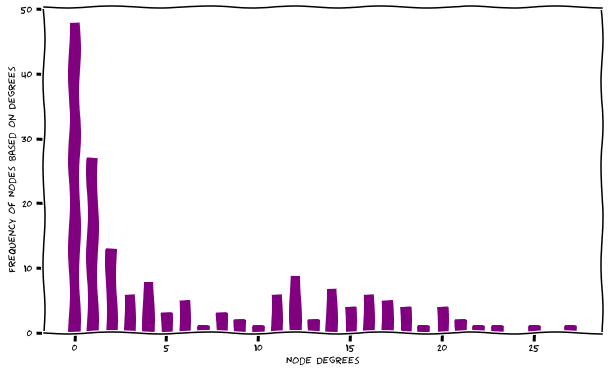

In [7]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = {}
for key in degree_sequence:
    if key not in degree_count:
        degree_count[key] = 1
    else:
        degree_count[key] += 1

node_degree, node_numbers = list(degree_count.values()), list(degree_count.keys())
plt.figure(figsize=(10, 6))
plt.bar(node_numbers, node_degree, color='purple', width=0.6)
plt.xlabel("Node Degrees")
plt.ylabel("Frequency of Nodes Based on Degrees")
plt.show()

5. Clustering Coefficient (global, average local, histogram of locals).

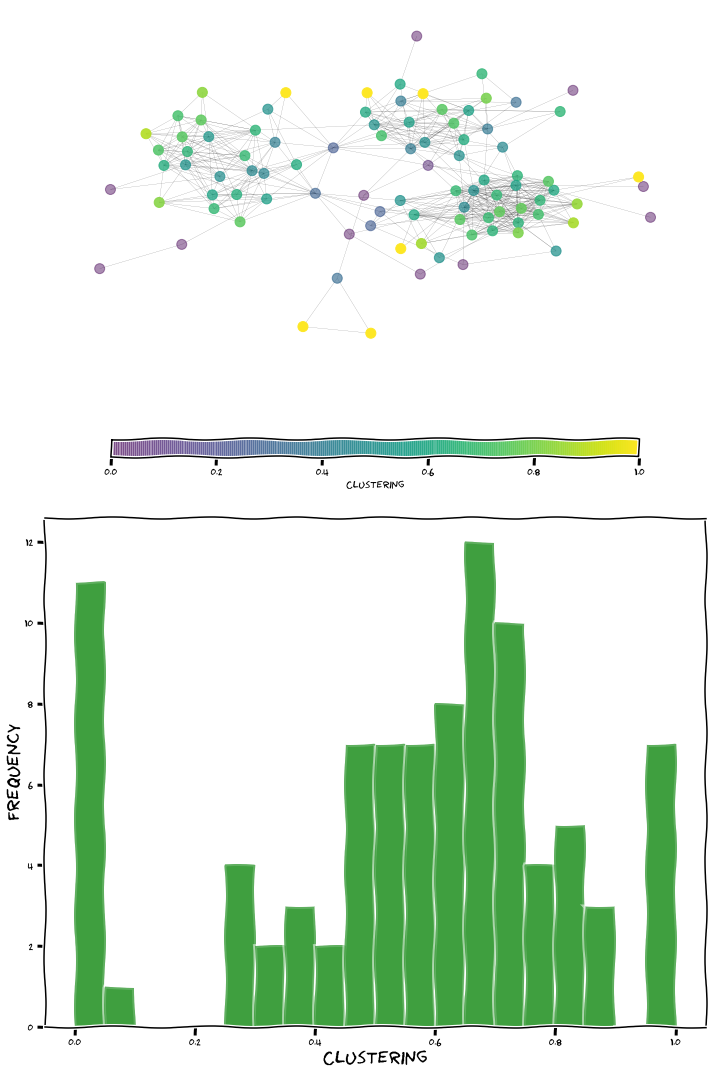

In [8]:
def customized_color(name_cmap, alpha):
  cmap = plt.get_cmap(name_cmap)
  custom_cmap = cmap(np.arange(cmap.N))
  custom_cmap[:,-1] = np.linspace(alpha, 1, cmap.N)
  custom_cmap = ListedColormap(custom_cmap)
  return custom_cmap

def pos_layout(g):
  df = pd.DataFrame(index=g.nodes(), columns=g.nodes())
  for row, data in nx.shortest_path_length(g):
      for col, dist in data.items():
          df.loc[row,col] = dist

  df = df.fillna(df.max().max())
  return df


cluster_coef = nx.clustering(gig_component)
cmap = customized_color('viridis', 0.45)
norm = plt.Normalize(0, max(cluster_coef.values()))
node_colors = [cmap(norm(cluster_coef[node])) for node in gig_component.nodes]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 15))

df = pos_layout(gig_component)

pos = nx.kamada_kawai_layout(gig_component, dist=df.to_dict())
nx.draw(gig_component, 
        node_color=node_colors, 
        ax=ax1,
        pos=pos, 
        node_size=100, 
        width=0.1)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), 
             label='Clustering', 
             shrink=0.8, 
             ax=ax1,
             aspect=30,
             orientation="horizontal")
ax1.tick_params(labelsize=25) 

ax1.margins(0.1,0.1)
ax2.hist(cluster_coef.values(), bins=20,alpha=0.5, color='green')
ax2.set_xlabel('Clustering', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)

plt.tight_layout()
plt.show()

6.   Average Path Length (+ histogram)

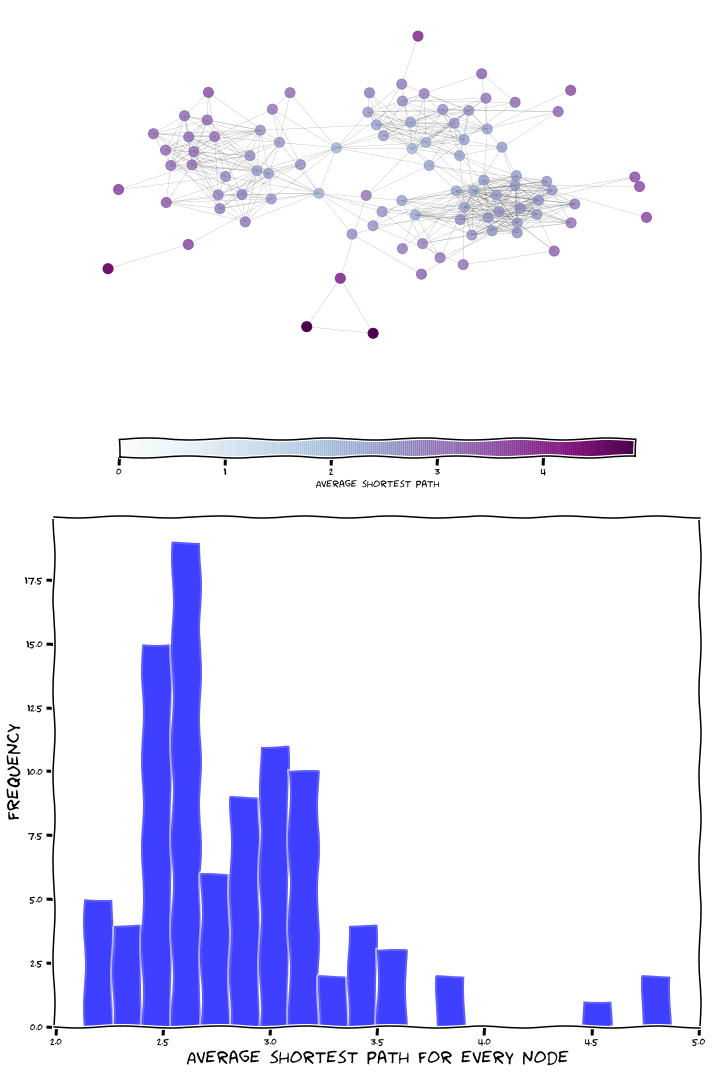

In [9]:
path_lens = {}
for node, path_len in nx.all_pairs_shortest_path_length(gig_component):
  path_means = np.mean(list(path_len.values()))
  path_lens[node] = path_means

cmap = customized_color('BuPu', 0.45)

norm = plt.Normalize(0, max(path_lens.values()))
node_colors = [cmap(norm(path_lens[node])) for node in gig_component.nodes]
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 15))

pos = nx.kamada_kawai_layout(gig_component, dist=df.to_dict())
nx.draw(gig_component, 
        node_color=node_colors, 
        ax=ax1,
        pos=pos, 
        node_size=100, 
        width=0.1)
fig.colorbar(ScalarMappable(cmap=cmap, norm=norm), 
             label='Average shortest path', 
             shrink=0.8, 
             ax=ax1,
             aspect=30,
             orientation="horizontal")
ax1.tick_params(labelsize=25) 

ax1.margins(0.1,0.1)
ax2.hist(path_lens.values(), bins=20,alpha=0.5, color='blue')
ax2.set_xlabel('Average shortest path For every node', fontsize=18)
ax2.set_ylabel('Frequency', fontsize=18)

plt.tight_layout()
plt.show()

7.   Degree distribution, fitting models and coefficient from regression/MLE/KS-test.

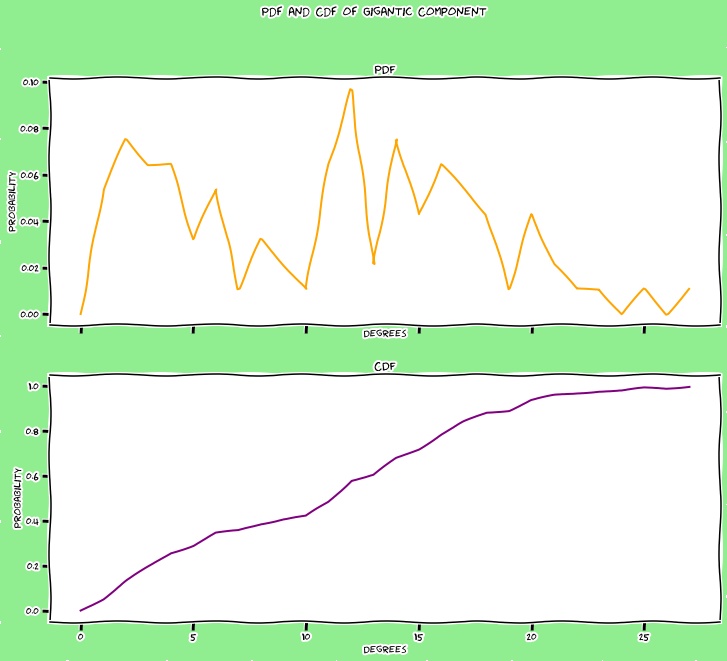

In [10]:
def gigantic_component_pdf(graph):
    return [deg_freq/len(graph.nodes) for deg_freq in nx.degree_histogram(graph)]

def gigantic_component_cdf(graph):
    pdfs = gigantic_component_pdf(graph)
    return np.cumsum(pdfs)

pdf = gigantic_component_pdf(gig_component)
cdf = gigantic_component_cdf(gig_component)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 10), facecolor='lightgreen')
ax[0].plot(pdf, color='orange')
ax[0].set_title('PDF')
ax[0].set_xlabel('Degrees')
ax[0].set_ylabel('Probability')

ax[1].plot(cdf, color='purple')
ax[1].set_title('CDF')
ax[1].set_xlabel('Degrees')
ax[1].set_ylabel('Probability')
plt.suptitle("Pdf and Cdf of Gigantic Component")
plt.show()

Log Scale

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

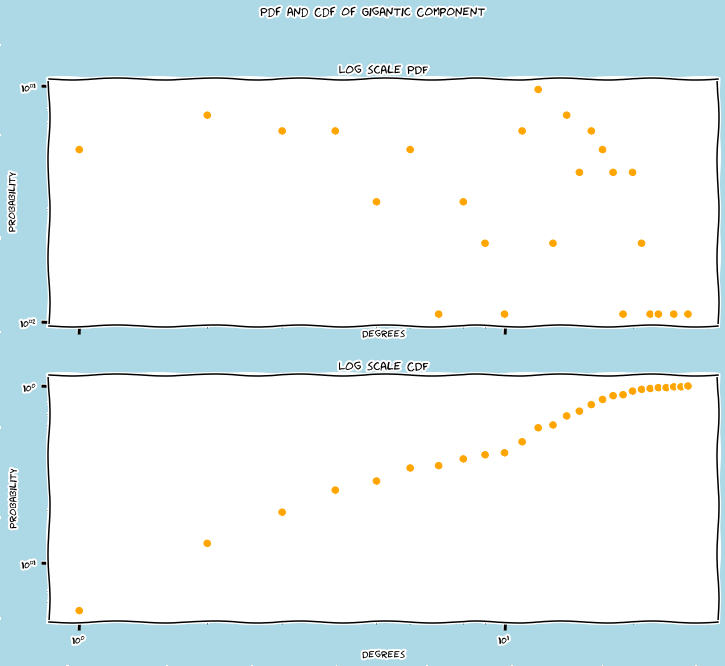

In [11]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12, 10), facecolor='lightblue')
ax[0].loglog(np.arange(0, len(pdf)),
             pdf,
             color='orange',
             marker='o',
             linestyle='None')
ax[0].set_title('Log scale PDF')
ax[0].set_xlabel('Degrees')
ax[0].set_ylabel('Probability')

ax[1].loglog(np.arange(0, len(cdf)),
             cdf,
             color='orange',
             marker='o',
             linestyle='None')
ax[1].set_title('Log scale CDF')
ax[1].set_xlabel('Degrees')
ax[1].set_ylabel('Probability')
plt.suptitle("Pdf and Cdf of Gigantic Component")
plt.show()

In [12]:
def power_law_pdf(x, alpha=3.5, x_min=1):
    C = (alpha - 1) / x_min ** (1 - alpha)
    return C * x ** (-alpha)

def power_law_cdf(x, alpha=3.5, x_min=1):
    F_x = (x_min / x) ** (alpha-1)
    return 1 - F_x

def mle_power_law_params(degree_sequence):
    best_kstest = None
    sorted_x_train = np.sort(degree_sequence)
    x_mins = range(int(np.min(sorted_x_train)), int(np.max(sorted_x_train)))
    for i in range(len(x_mins)):
        x_min = x_mins[i]
        x_train = sorted_x_train[sorted_x_train >= x_min]
        alpha = 1 + len(x_train) * np.sum(np.log(x_train / x_min))**(-1)
        ks_test = kstest(x_train, lambda x:power_law_cdf(x, alpha, x_min))[0]
        
        if (best_kstest is None): # making sure it runs atleast once
            best_alpha, best_x_min, best_kstest = alpha, x_min, ks_test
        elif (best_kstest > ks_test):
            best_alpha, best_x_min, best_kstest = alpha, x_min, ks_test
      
    return best_alpha, best_x_min

def alpha_log_bins(x_train, bins):
    log_bins = np.logspace(np.log10(x_train.min()), np.log10(x_train.max()), bins)
    histogram = np.histogram(x_train, log_bins, density=True)
    density = histogram[0][np.where(histogram[0] != 0)]
    density = np.log(density / len(x_train))
    bin_centers = np.log((histogram[1][1:] + histogram[1][:-1]) / 2)
    bin_centers = bin_centers[np.where(histogram[0] != 0)].reshape(-1, 1)
    model = LinearRegression()
    model.fit(bin_centers, density)
    return abs(np.squeeze(model.coef_))

<Figure size 864x720 with 0 Axes>

Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '-' [U+2212], substituting with a dummy symbol.
Font 'default' does n

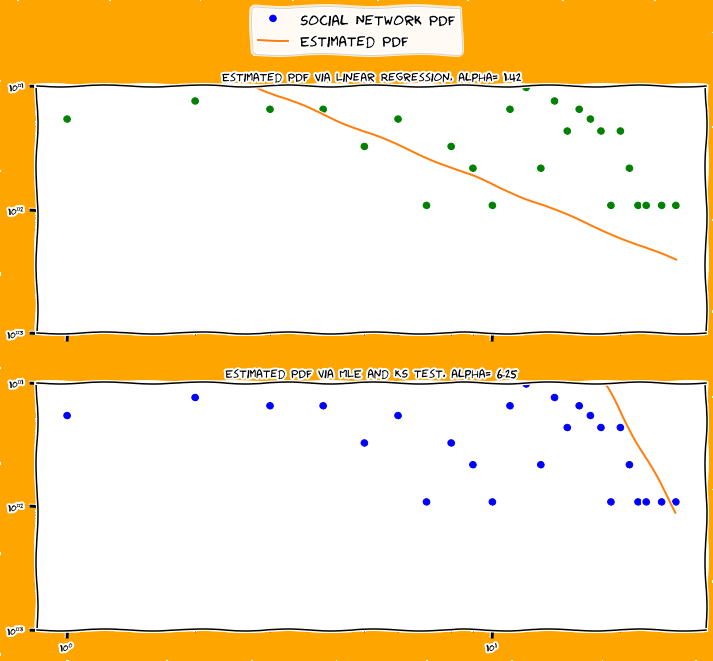

In [13]:
bins = 100
degree_sequence = np.array(list(dict(nx.degree(gig_component)).values()))
x_min = degree_sequence.min()

binning = np.logspace(np.log10(x_min), np.log10(degree_sequence.max()), bins)
hist, bin_edges = np.histogram(degree_sequence, bins=binning, density=True)
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
x_space = np.linspace(x_min, degree_sequence.max(), 100)


plt.figure(figsize=(12, 10))   
plt.rcParams['axes.grid'] = False
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, figsize=(12, 10), facecolor='orange')


ax1.loglog(np.arange(0, len(pdf)), 
           pdf, 
           color='green', 
           marker='o', 
           linestyle='None',
           label='Social Network PDF')
hat_alpha_reg = alpha_log_bins(degree_sequence, bins)
ax1.loglog(x_space, power_law_pdf(x_space, hat_alpha_reg, x_min), 
         label='Estimated PDF', c='tab:orange')
ax1.set_title('Estimated PDF via Linear Regression, alpha= {:.2f}'.format(hat_alpha_reg))
ax1.set_ylim(0.001, 0.1)
        
ax2.loglog(np.arange(0, len(pdf)), 
           pdf, 
           color='blue', 
           marker='o', 
           linestyle='None',
           label='Social Network PDF')
hat_alpha, hat_x_min = mle_power_law_params(degree_sequence)
ax2.loglog(x_space, power_law_pdf(x_space, hat_alpha, hat_x_min), 
         label='Estimated PDF', c='tab:orange')
ax2.set_title('Estimated PDF via MLE and KS test, alpha= {:.2f}'.format(hat_alpha))
ax2.set_ylim(0.001, 0.1)
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', prop={'size': 15})

plt.show()

8.   Gorgeous network layout.

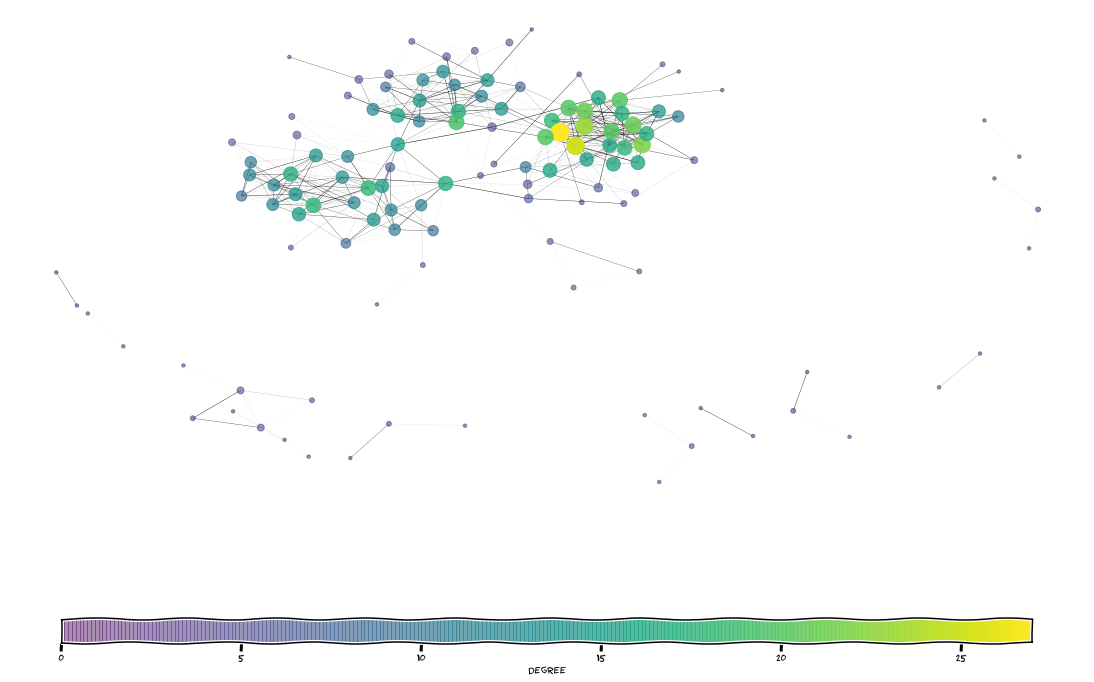

In [14]:
node_degree = nx.degree(G)
norm = plt.Normalize(0, max(dict(node_degree).values()))
cmap = customized_color('viridis', 0.45)
node_colors = [cmap(norm(dict(node_degree)[node])) for node in G.nodes]

elem = list(G.degree)
node_sizes, edge_width_list = [], []
for e in elem:
  edge_width_list.append(e[1])
  node_sizes.append(e[1] * 12)

edge_width = ((edge_width_list/np.max(edge_width_list))/2) + 0.02


plt.figure(figsize=(15, 10))
df_g = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df_g.to_dict())
nx.draw(G, 
        node_color=node_colors, 
        pos=pos, 
        node_size=node_sizes,
        width=edge_width)
plt.colorbar(ScalarMappable(cmap=cmap, norm=norm), 
             label='Degree', 
             shrink=0.9,
             aspect=40,
             orientation="horizontal")
plt.show()

Number of friends divided by gender:
Male: 139
Female: 29
Not Defined: 3



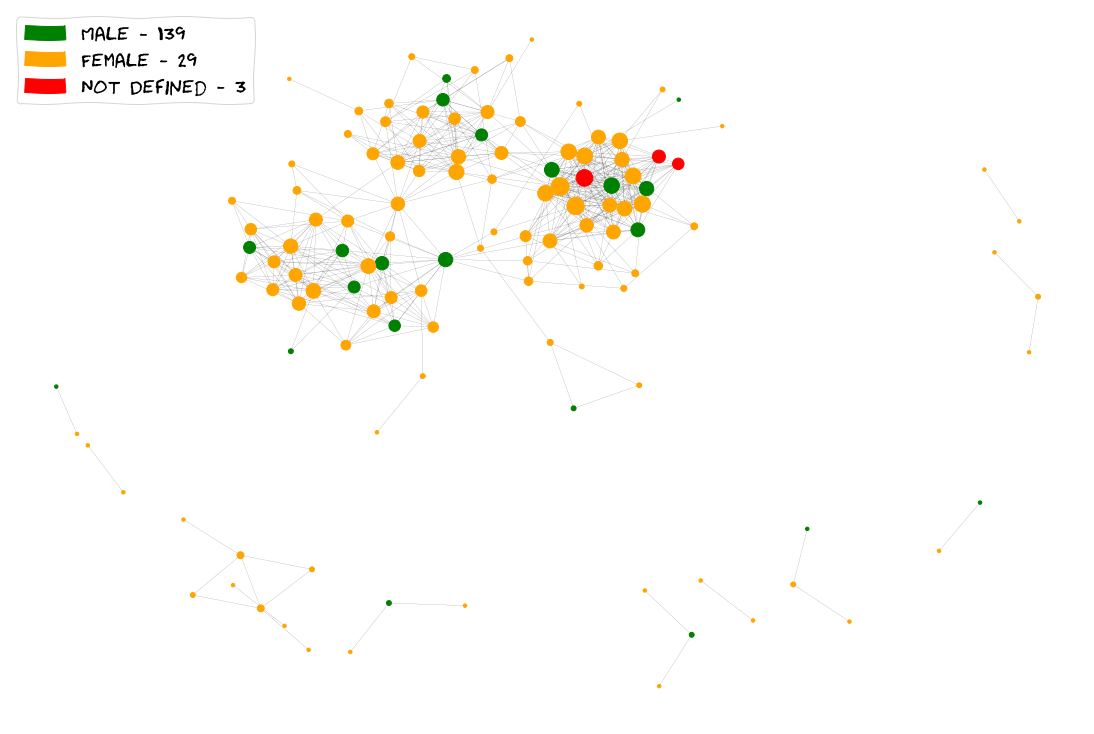

In [41]:
sex_info = Counter(nx.get_node_attributes(G,'sex').values()).most_common()
print('Number of friends divided by gender:')
print('Male:', sex_info[0][1])
print('Female:',sex_info[1][1])
print('Not Defined:',sex_info[2][1])
print("")

node_sex = nx.get_node_attributes(G,'sex') 
node_colors = []
for node in G.nodes:
  if node_sex[node] == 1:
    node_colors.append('orange')
  elif node_sex[node] == 0:
    node_colors.append('red')
  else:
    node_colors.append('green')

plt.figure(figsize=(15, 10))
df_g = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df_g.to_dict())
nx.draw(G, 
        node_color=node_colors,
        pos=pos, 
        node_size=node_sizes,
        width=0.1)
purple_patch = mpatches.Patch(color='green', label='Male - '+str(sex_info[0][1]))
yellow_patch = mpatches.Patch(color='orange', label='Female - '+str(sex_info[1][1]))
red_patch = mpatches.Patch(color='red', label='Not Defined - '+str(sex_info[2][1]))

plt.legend(handles=[purple_patch, yellow_patch, red_patch], fontsize=20, loc='upper left')

plt.show()

## Structural Analysis

Tasks:

1.   The closest random graph model similar to your social network (compare at least three models from lectures, such as ER, BA, WS). Check three real-world network properties on chosen random graph models and your ego-network, compare the results.
2.   Degree/Closeness/Betweenness centralities (optional: Katz, Bonacich). 
3.   Top nodes interpretation (not just surnames, but how are they related to you).
4.   Page-Rank. HITS. Correlation comparison of centralities and prestige. Comparison of top nodes.
5.   Assortative Mixing according to node attributes (usually sex, city, educational status).
6.   Node structural equivalence/similarity (interpret how they are similar from communicative patterns).

1.   The closest random graph model similar to your social network (compare at least three models from lectures, such as ER, BA, WS). Check three real-world network properties on chosen random graph models and your ego-network, compare the results.

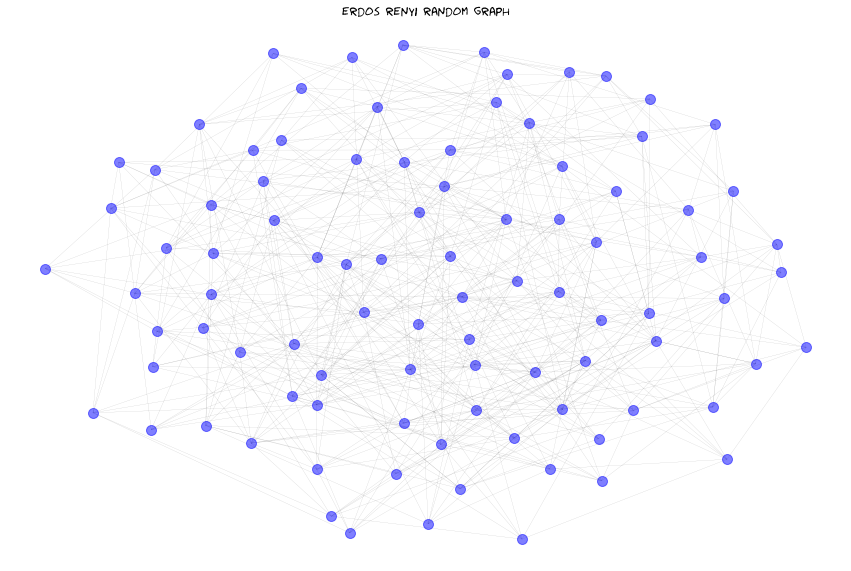

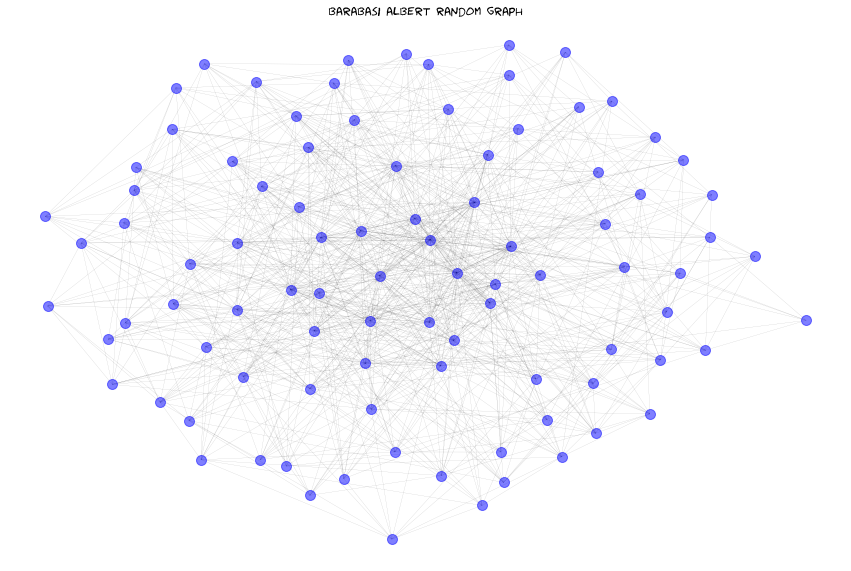

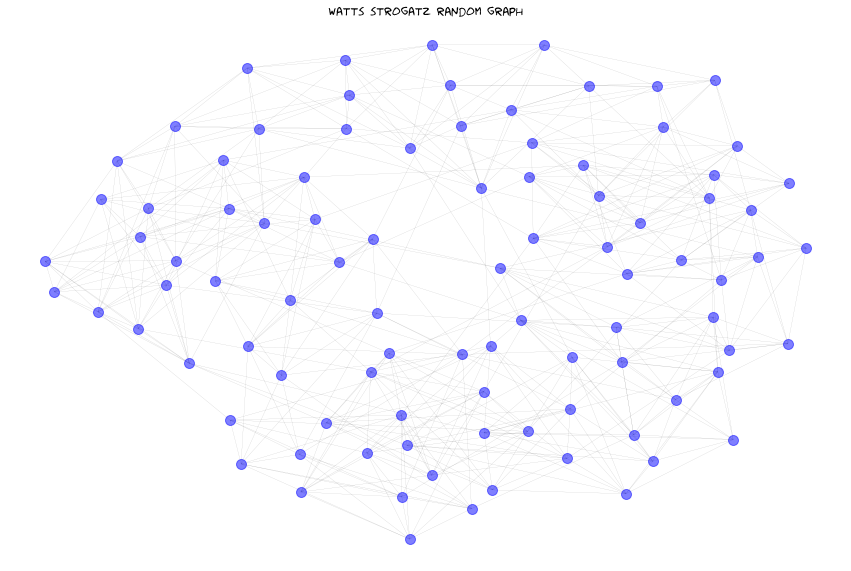

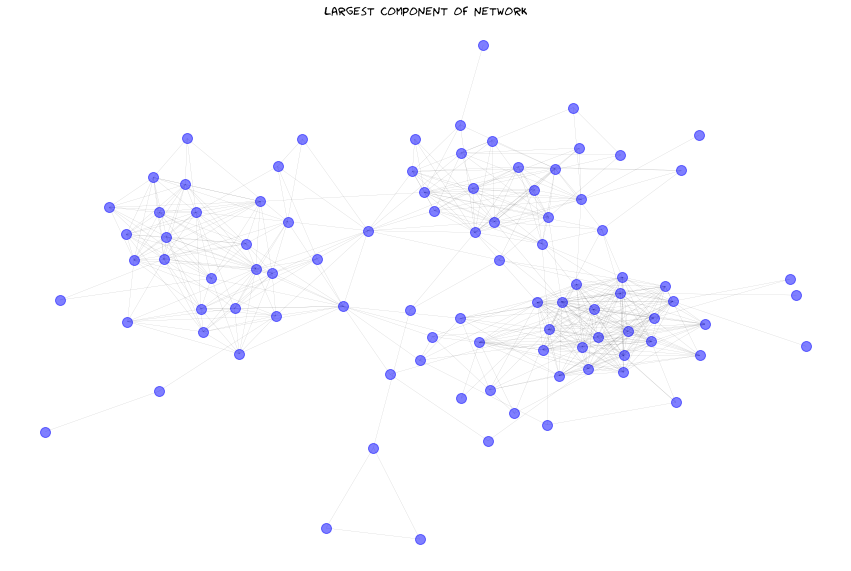

In [16]:
n_nodes = len(gig_component.nodes())
avg_edges = np.array([d for n, d in gig_component.degree()]).mean()
prob = avg_edges/n_nodes

# Erdos Reny
er_g = nx.fast_gnp_random_graph(n_nodes, prob, seed=1)

# Barbasi Albert
ba_g = nx.barabasi_albert_graph(n_nodes, int(avg_edges), seed=1)

# Watts-Strogatz
ws_g = nx.watts_strogatz_graph(n_nodes, int(avg_edges), p=0.1, seed=1)

rgs = {'erdos renyi random graph': er_g,
       'barabasi albert random graph':ba_g,
       'watts strogatz random graph':ws_g,
       'largest component of network': gig_component}

for rg_title, rg in rgs.items():
    df = pos_layout(rg)
    pos = nx.kamada_kawai_layout(rg, dist=df.to_dict())
    plt.figure(figsize=(15, 10))
    plt.title(rg_title)
    nx.draw(rg, 
            pos=pos,
            width=0.1,
            node_color='blue',
            node_size=100,
            alpha=0.5)
    plt.show()

In [17]:
def graph_properties(g):
  diameter = nx.diameter(g)
  radius = nx.radius(g)
  avg_path = nx.average_shortest_path_length(g)
  clustering = nx.average_clustering(g)
  return {'diameter': diameter,
          'radius': radius,
          'avg shortest path': avg_path,
          'avg clustering': clustering}

def get_gk(expected, actual, sigma): 
  return {k: (math.exp(-(expected[k]-actual[k])**2/(2*sigma[k]**2))) for k in actual}

In [18]:
sigma = {'diameter': 3,
          'radius': 1,
          'avg shortest path': 1,
          'avg clustering': 0.001}

gig_component_prop = graph_properties(rgs['largest component of network'])
gk_dict = {}
rg_prop_dict = {}

for rg_title, rg in rgs.items():
  rg_prop = graph_properties(rg)
  gk = get_gk(gig_component_prop, rg_prop, sigma)
  rg_prop_dict[rg_title] = rg_prop 
  gk_dict[rg_title] = gk

df1 = pd.DataFrame().from_dict(rg_prop_dict)
df1['sigma'] = pd.Series(sigma)

df2 = pd.DataFrame().from_dict(gk_dict)
df2 = df2.transpose()
df2['Total Score'] = df2.sum(axis=1)/4
display(df1.transpose())
print('')
display(df2)

diameter  ...  avg clustering
erdos renyi random graph           3.0  ...        0.113438
barabasi albert random graph       3.0  ...        0.312596
watts strogatz random graph        4.0  ...        0.484400
largest component of network       7.0  ...        0.557361
sigma                              3.0  ...        0.001000

[5 rows x 4 columns]

diameter    radius  ...  avg clustering  Total Score
erdos renyi random graph      0.411112  0.606531  ...             0.0     0.439606
barabasi albert random graph  0.411112  0.135335  ...             0.0     0.279358
watts strogatz random graph   0.606531  0.606531  ...             0.0     0.539253
largest component of network  1.000000  1.000000  ...             1.0     1.000000

[4 rows x 5 columns]

2.   Degree/Closeness/Betweenness centralities (optional: Katz, Bonacich).
3.   Top nodes interpretation (not just surnames, but how are they related to you).

In [19]:
def centralities(G: nx.Graph):
    central = {}
    central['degree'] = np.array(list(nx.degree_centrality(G).values()))
    central['closeness'] = np.array(list(nx.closeness_centrality(G).values()))
    central['betweenness'] = np.array(list(nx.betweenness_centrality(G).values()))
    return central

def top10_centralities(G: nx.Graph):
    top10_centralities_dict = {}
    for i, j in zip(['degree', 'closeness', 'betweenness'], [nx.degree_centrality, nx.closeness_centrality, nx.betweenness_centrality]):            
        top10_deg_cent = sorted(j(G).items(), key=lambda x: x[1], reverse=True)[:10]
        ids, centrality = zip(*top10_deg_cent)
        sex = [G.nodes[id]['sex'] for id in ids]
        names = [G.nodes[id]['label'] for id in ids]
        top10_centralities_dict[i] = pd.DataFrame({'id': ids,'name':names , 'sex':sex, 'centrality': centrality})
    return top10_centralities_dict

c = centralities(G)
top_dfs = top10_centralities(G)
top_dfs

{'betweenness':           id                  name  sex  centrality
 0  169716343   Владимир Спиранских    2    0.063040
 1  337892544     Наталья Романчева    1    0.048627
 2  176213099       Мария Ястребова    1    0.037173
 3  222783240          Оля Магунова    1    0.027016
 4  112793838           Лина Махова    1    0.025188
 5  289269459  Маргарита Резниченко    1    0.023602
 6  154649788   Анастасия Николаева    1    0.019751
 7   58242096        Соня Ахманаева    1    0.018657
 8  145514474    Вероника Мезенцева    1    0.017737
 9   53045513     Соня Белопольская    1    0.016468,
 'closeness':           id                  name  sex  centrality
 0  176213099       Мария Ястребова    1    0.251456
 1  155211487        Мария Шурупова    1    0.242869
 2  169716343   Владимир Спиранских    2    0.241690
 3  337892544     Наталья Романчева    1    0.240523
 4  222783240          Оля Магунова    1    0.237087
 5  247082977       Марина Миронова    1    0.228386
 6  112793838    

In [20]:
top_dfs = top10_centralities(G)
top_name_center_dict = {}
for k,v in top_dfs.items():
  top_name_center = top_dfs[k][['name']][:3].set_index(top_dfs[k]['id'][:3]).to_dict()['name']
  top_name_center_dict[k]=top_name_center
top_name_center_dict

{'betweenness': {'169716343': 'Владимир Спиранских',
  '176213099': 'Мария Ястребова',
  '337892544': 'Наталья Романчева'},
 'closeness': {'155211487': 'Мария Шурупова',
  '169716343': 'Владимир Спиранских',
  '176213099': 'Мария Ястребова'},
 'degree': {'136717675': 'Слава Ежкова',
  '222783240': 'Оля Магунова',
  '53553851': 'Аня Князева'}}

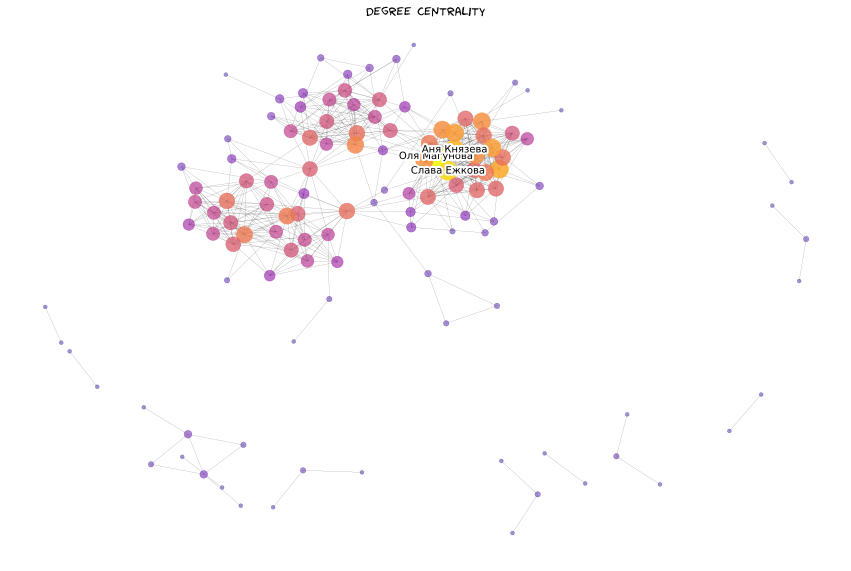

id                 name  sex  centrality
0  222783240         Оля Магунова    1    0.158824
1  136717675         Слава Ежкова    1    0.147059
2   53553851          Аня Князева    0    0.135294
3   50990055      Виктория Лобода    1    0.129412
4  112469438  Анастасия Каймакова    1    0.123529
5  168677202  Анастасия Каменская    1    0.123529
6   13563399      Оля Стальгорова    1    0.117647
7   85683456         Аня Каширина    1    0.117647
8  247082977      Марина Миронова    1    0.117647
9  290104751   София Ксенофонтова    2    0.117647

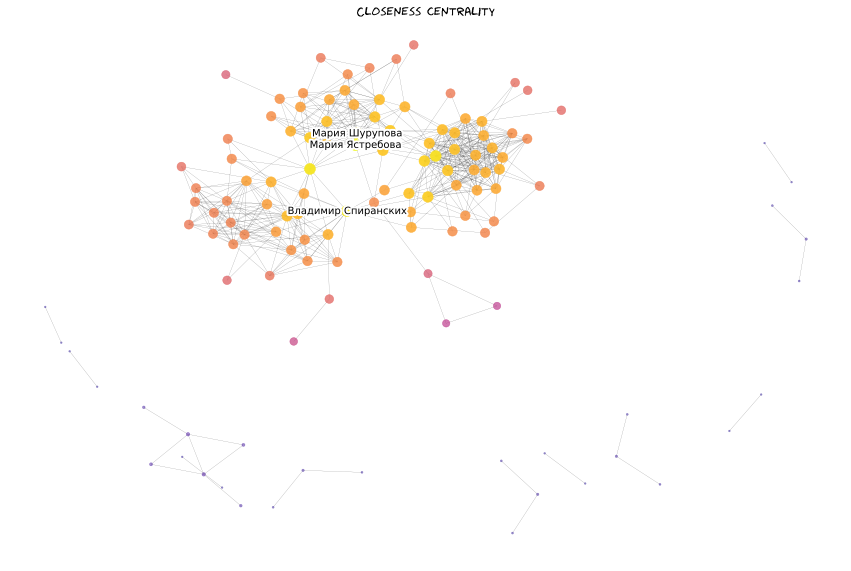

id                  name  sex  centrality
0  176213099       Мария Ястребова    1    0.251456
1  155211487        Мария Шурупова    1    0.242869
2  169716343   Владимир Спиранских    2    0.241690
3  337892544     Наталья Романчева    1    0.240523
4  222783240          Оля Магунова    1    0.237087
5  247082977       Марина Миронова    1    0.228386
6  112793838           Лина Махова    1    0.226310
7  289269459  Маргарита Резниченко    1    0.224271
8  140645785   Наталья Поротникова    1    0.223266
9  136717675          Слава Ежкова    1    0.221281

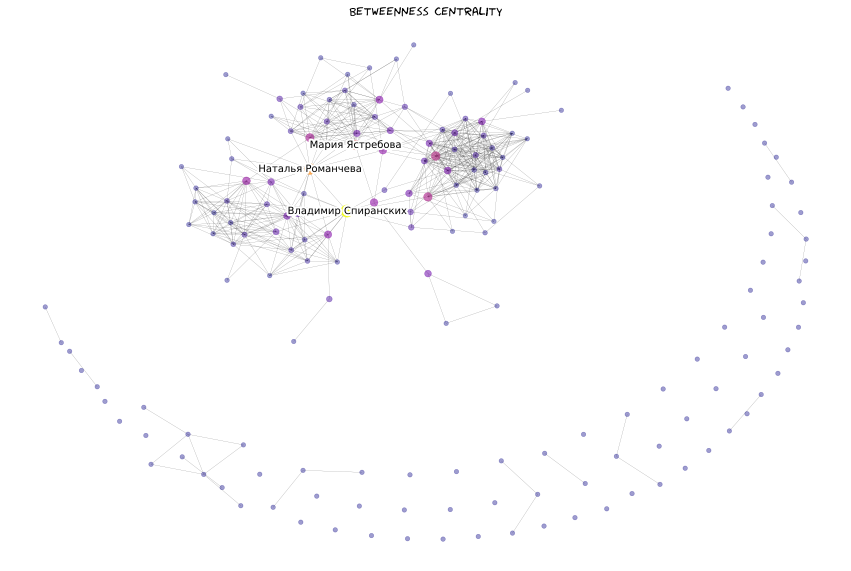

id                  name  sex  centrality
0  169716343   Владимир Спиранских    2    0.063040
1  337892544     Наталья Романчева    1    0.048627
2  176213099       Мария Ястребова    1    0.037173
3  222783240          Оля Магунова    1    0.027016
4  112793838           Лина Махова    1    0.025188
5  289269459  Маргарита Резниченко    1    0.023602
6  154649788   Анастасия Николаева    1    0.019751
7   58242096        Соня Ахманаева    1    0.018657
8  145514474    Вероника Мезенцева    1    0.017737
9   53045513     Соня Белопольская    1    0.016468

In [21]:
cases = [['degree', 2500, 0, 'Degree centrality'], 
         ['closeness', 500, 0, 'Closeness centrality'], 
         ['betweenness', 2000, 20, 'Betweenness centrality']]
my_cmap = customized_color('plasma', 0.4)
df = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df.to_dict())
for c_key, scale, bias, title in cases:
    label = top_name_center_dict[c_key]
    plt.figure(figsize=(15, 10))
    plt.title(title)
    nx.draw(G, 
            pos=pos,
            width=0.1,
            linewidths=0.5,
            cmap=my_cmap,
            node_size=c[c_key]*scale + bias,
            node_color=c[c_key])
    nx.draw_networkx_labels(G, pos=pos, labels=label, font_size=10)
    plt.show()
    display(top_dfs[c_key][:10])



*   Degree Centrality
    1. ```Оля Магунова``` is close friend of user.
    2. ```Слава Ежкова``` is close friend of user.
    3. ```Аня Князева``` is close friend of user.

*   Closeness Centrality
    1. ```Мария Ястребова``` is close friend of user.
    2. ```Мария Шурупова```	is close friend of user.
    3. ```Владимир Спиранских``` is close friend of user.

*   Betweenness Centrality
    1. ```Владимир Спиранских``` is close friend of user.
    2. ```Наталья Романчева``` is close friend of user.
    3. ```Мария Ястребова``` is close friend of user.


4.   Page-Rank. HITS. Correlation comparison of centralities and prestige. Comparison of top nodes.

id             name  sex  centrality
0  222783240     Оля Магунова    1    0.015547
1  136717675     Слава Ежкова    1    0.014864
2  176213099  Мария Ястребова    1    0.014246
3  189082800       Оля Коваль    1    0.012664
4  349915855  Таня Даларнская    1    0.012664

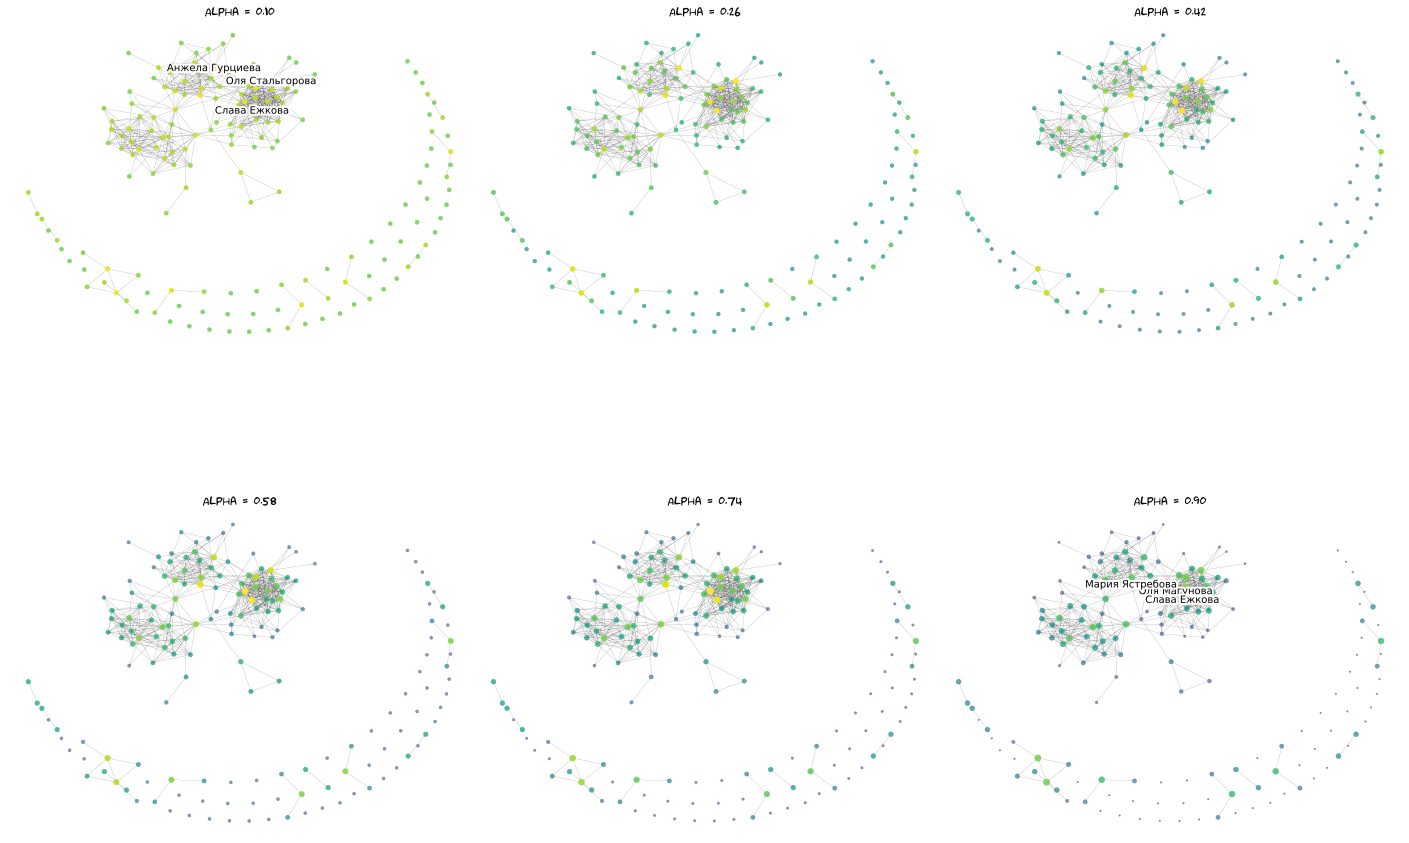

In [22]:
def top10_pagerank(G, alpha):
    top10_centralities_dict = {}      
    top10_deg_page = sorted(list(nx.pagerank(G, alpha).items()), key=lambda x:x[1], reverse=True)[:10]
    ids, centrality = zip(*top10_deg_page)
    sex = [G.nodes[id]['sex'] for id in ids]
    names = [G.nodes[id]['label'] for id in ids]
#         relation = [G.nodes[id]['relation'] for id in ids]
    top10_centralities_dict = pd.DataFrame({'id': ids,'name':names , 'sex':sex, 'centrality': centrality})
    return top10_centralities_dict



cmap = customized_color('viridis', 0.45)
PR_alphas = np.arange(0.1, 1, 0.16)

df = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df.to_dict())

fig, axes = plt.subplots(2,3, figsize=(25,15))
fig.subplots_adjust(hspace = .5, wspace=.001)
axe = axes.ravel()

for alpha, i in zip(PR_alphas,np.arange(0,6)):
    top_dfs_pr = top10_pagerank(G, alpha)
    top_name_pr = top_dfs_pr[['name']][:3].set_index(top_dfs_pr['id'][:3]).to_dict()['name']
    PR = nx.pagerank(G, alpha)
    node_size = [pr*3e3 for node, pr in PR.items()]
    norm = plt.Normalize(0, max(PR.values()))
    node_colors = [cmap(norm(PR[node])) for node in G.nodes]


    axe[i].set_title('Alpha = {:.2f}'.format(alpha))
    nx.draw(G, 
            pos=pos,
            width=0.1,
            linewidths=0.5,
            node_size=node_size,
            node_color=node_colors,
            ax=axe[i]
            ) 
    if i in [0,5]:
      nx.draw_networkx_labels(G, 
                              pos=pos, 
                              labels=top_name_pr, 
                              font_size=10,
                              ax=axe[i])

display(top10_pagerank(G, 0.85)[:5])

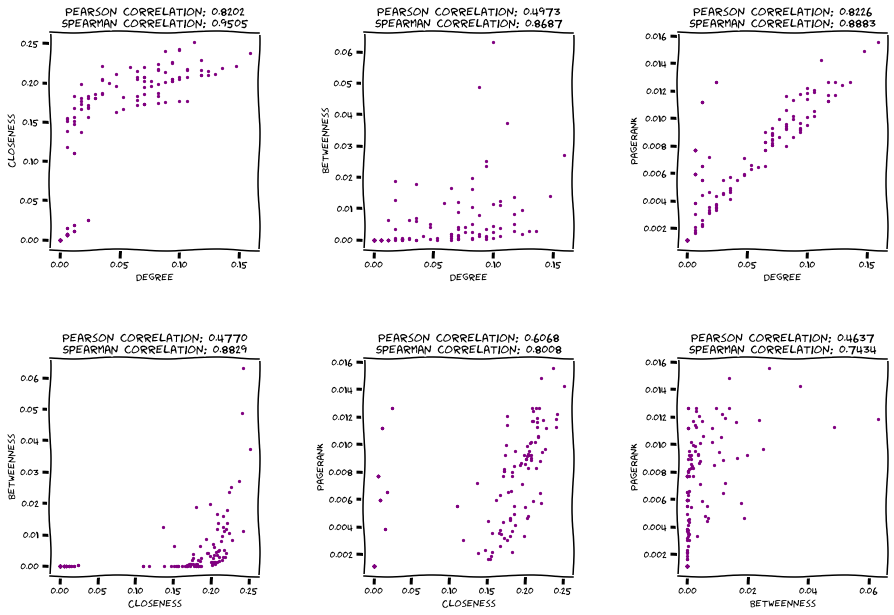

In [23]:
def pearson(a,b):
    return np.corrcoef(a, b)[0][1]
def spearman(a,b):
    return spearmanr(a, b)[0]

corrvals = [
    ('Degree', list(nx.degree_centrality(G).values())),
    ('Closeness', list(nx.closeness_centrality(G).values())),
    ('Betweenness', list(nx.betweenness_centrality(G).values())),
    ('PageRank', list(nx.pagerank(G).values()))
]

plt.figure(figsize=(3*5, 2*5))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
k = 1
for i in range(len(corrvals)):
    for j in range(i + 1, len(corrvals)):
        i_label, i_vals = corrvals[i]
        j_label, j_vals = corrvals[j]
        pcorrelation = pearson(i_vals, j_vals)
        scorrelation = spearman(i_vals, j_vals)
        plt.subplot(2, 3, k)
        plt.scatter(i_vals, j_vals, s=5, color='purple')
        plt.title('Pearson correlation: {:.4f}\nSpearman correlation: {:.4f}'.format(pcorrelation, scorrelation))
        plt.xlabel(i_label)
        plt.ylabel(j_label)
        k += 1

5.   Assortative Mixing according to node attributes (usually sex, city, educational status).

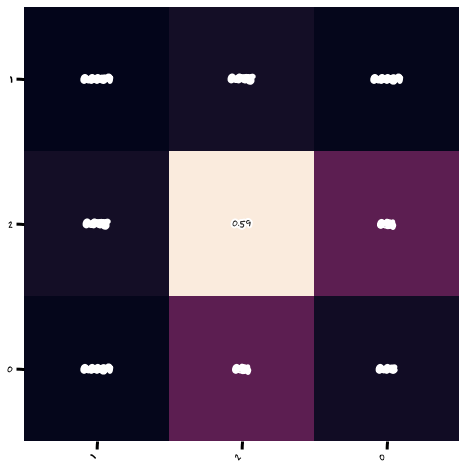

In [24]:
def genre_mixing(G):
  mixing = nx.attribute_mixing_matrix(G, 'sex')
  attr_val = nx.get_node_attributes(G, 'sex')
  mapping = {}

  index = 0
  for key in attr_val:
    if(attr_val[key] not in mapping):
      mapping[attr_val[key]] = index
      index += 1

  return mixing, mapping

mixing, mapping = genre_mixing(gig_component)

fig = plt.figure(figsize=(8, 8))

hmap = sns.heatmap(
    mixing,
    cbar=False,
    annot=True,
    square=True)
hmap.set_xticklabels(
    labels=[m for m in mapping], 
    rotation=45, 
    horizontalalignment='right')
hmap.set_yticklabels(
    labels=[m for m in mapping], 
    rotation=0)
plt.show()

6.   Node structural equivalence/similarity (interpret how they are similar from communicative patterns).

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


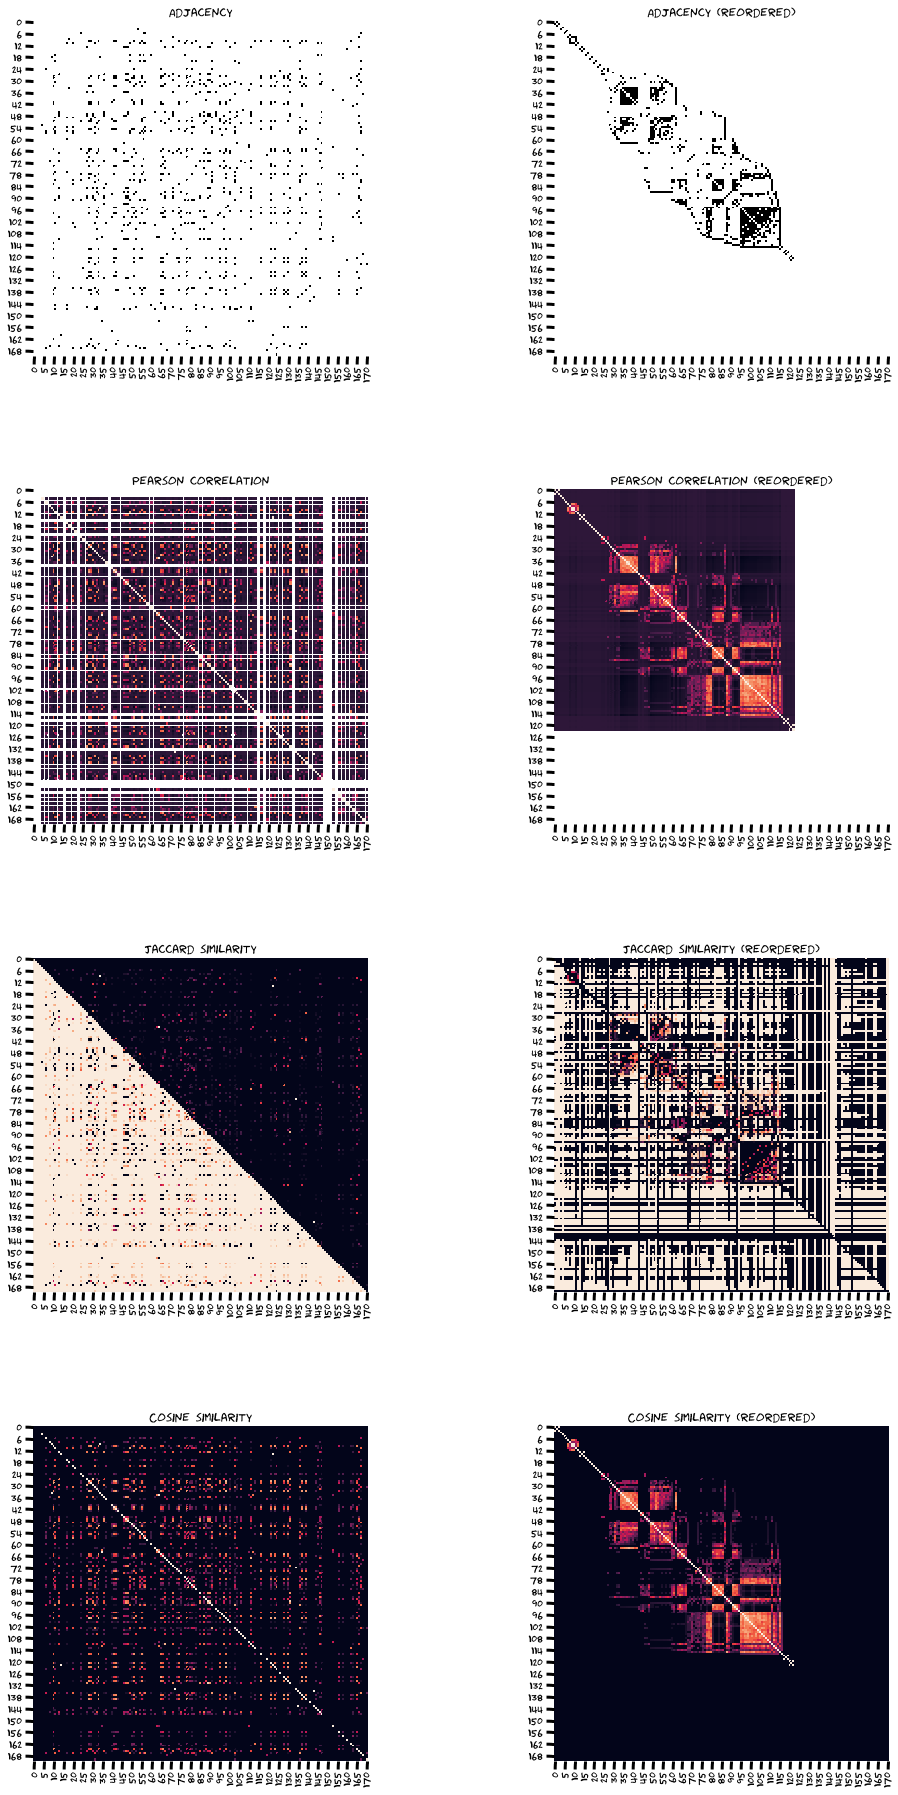

In [25]:
def sim_matrices(G):
  A = nx.to_numpy_array(G)
  pc = np.corrcoef(A)
  J = np.zeros(A.shape)
  for i, j, c in nx.jaccard_coefficient(nx.from_numpy_array(A)):
    J[i,j] = c 
    J[j,i] = 1-c 

  cs = cosine_similarity(A)
  
  return A, pc, J, cs

def cm_order(G):
  adj_matrix = nx.adjacency_matrix(G)

  return reverse_cuthill_mckee(adj_matrix)



A, corr, J, cos = sim_matrices(G)
order = cm_order(G)

fig = plt.figure(figsize=(16, 16*2))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

cases = [[1, A, plt.cm.Greys, 'Adjacency', range(len(nx.degree(G)))],
         [2, A, plt.cm.Greys, 'Adjacency (reordered)', order],
         [3, corr, None, 'Pearson correlation', range(len(nx.degree(G)))], 
         [4, corr, None, 'Pearson correlation (reordered)', order], 
         [5, J, None, 'Jaccard similarity', range(len(nx.degree(G)))], 
         [6, J, None, 'Jaccard similarity (reordered)', order], 
         [7, cos, None, 'Cosine similarity', range(len(nx.degree(G)))], 
         [8, cos, None, 'Cosine similarity (reordered)', order]]

for i, matrix, cmap, t, o in cases:
    plt.subplot(4, 2, i)
    hmap = sns.heatmap(
        matrix[np.ix_(o, o)],
        cmap=cmap,
        cbar=False,
        square=True)
    plt.title(t)

## Community Detection

Tasks:

1.   Clique search, k-cores visualization, and interpretation.
2.   Best results of various community detection algorithms, both in terms of interpretation and some quality criterion (modularity, silhouette, ground truth partition). 
3.   The results should be visible on the network layout.
4.   Interpretations should be written over image with community detection (use Paint, for e.g.)

1.   Clique search, k-cores visualization, and interpretation.

In [26]:
cliques = list(nx.find_cliques(G))
print("Number of Cliques :", len(cliques))
print("Average clique size", sum([len(clique)/len(cliques) for clique in cliques]))

Number of Cliques : 248
Average clique size 4.762096774193544


In [27]:
def largest_cliques(G):
    color = [random.random(), random.random(), random.random()]
    clique_list = list(nx.find_cliques(G))
    max_clique_length = max([len(i) for i in clique_list])
    largest_cliques = [i for i in clique_list if len(i) == max_clique_length]
    nodes_largest_cliques = list(set([j for i in largest_cliques for j in i]))
    rgb0, rgb1 = [], []
    width1, width2 = [], []
    for node in G.nodes:
        if node in largest_cliques[0]:
            rgb0.append(color)
        else:
            rgb0.append((1, 1, 1))
    for node in G.nodes:    
        if node in largest_cliques[1]:
            rgb1.append(color)
        else:
            rgb1.append((1, 1, 1))
            
    rgb = np.array([rgb0, rgb1])
    
    for edge1, edge2 in G.edges:
        if edge1 in largest_cliques[0] and edge2 in largest_cliques[0]:
            width1.append(2)
        else:
            width1.append(1)
    for edge1, edge2 in G.edges:
        if edge1 in largest_cliques[1] and edge2 in largest_cliques[1]:
            width2.append(2)
        else:
            width2.append(1)
    width = np.array([width1, width2])
    
    return largest_cliques, rgb, width

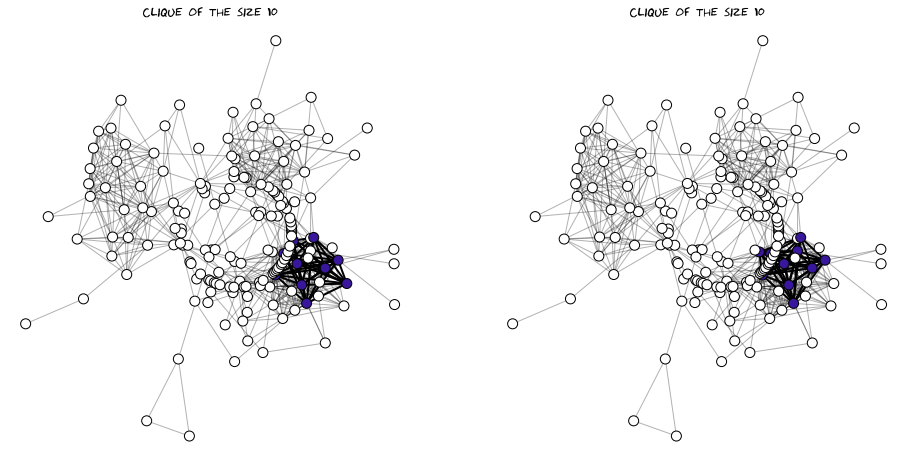

In [28]:
max_cliques, colors, widths = largest_cliques(G)

size = np.unique(colors[0], axis=0, return_counts=True)[1][0]
pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(8*2, 8))

for i in range(colors.shape[0]):
    
    b_edges = np.array(list(G.edges))[widths[i] == widths[i].max()]
    
    plt.subplot(1, 2, i+1)
    nodes = nx.draw_networkx_nodes(
        G, 
        pos,
        node_color=colors[i], 
        node_size=100, 
        linewidths=1, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(
        G,
        pos,
        alpha=0.3,
        width=widths[i].min()
    )
    nx.draw_networkx_edges(
        G,
        pos,
        width=widths[i].max(),
        edgelist=b_edges
    )
    plt.title('Clique of the size {}'.format(size))
    plt.axis('off')

In [29]:
def pos_layout(g):
  df = pd.DataFrame(index=g.nodes(), columns=g.nodes())
  for row, data in nx.shortest_path_length(g):
      for col, dist in data.items():
          df.loc[row,col] = dist

  df = df.fillna(df.max().max())
  return df
df_g = pos_layout(G)
pos = nx.kamada_kawai_layout(G, dist=df_g.to_dict())

In [30]:
def k_core_decompose(G):
    return np.array(list(nx.core_number(G).values()))

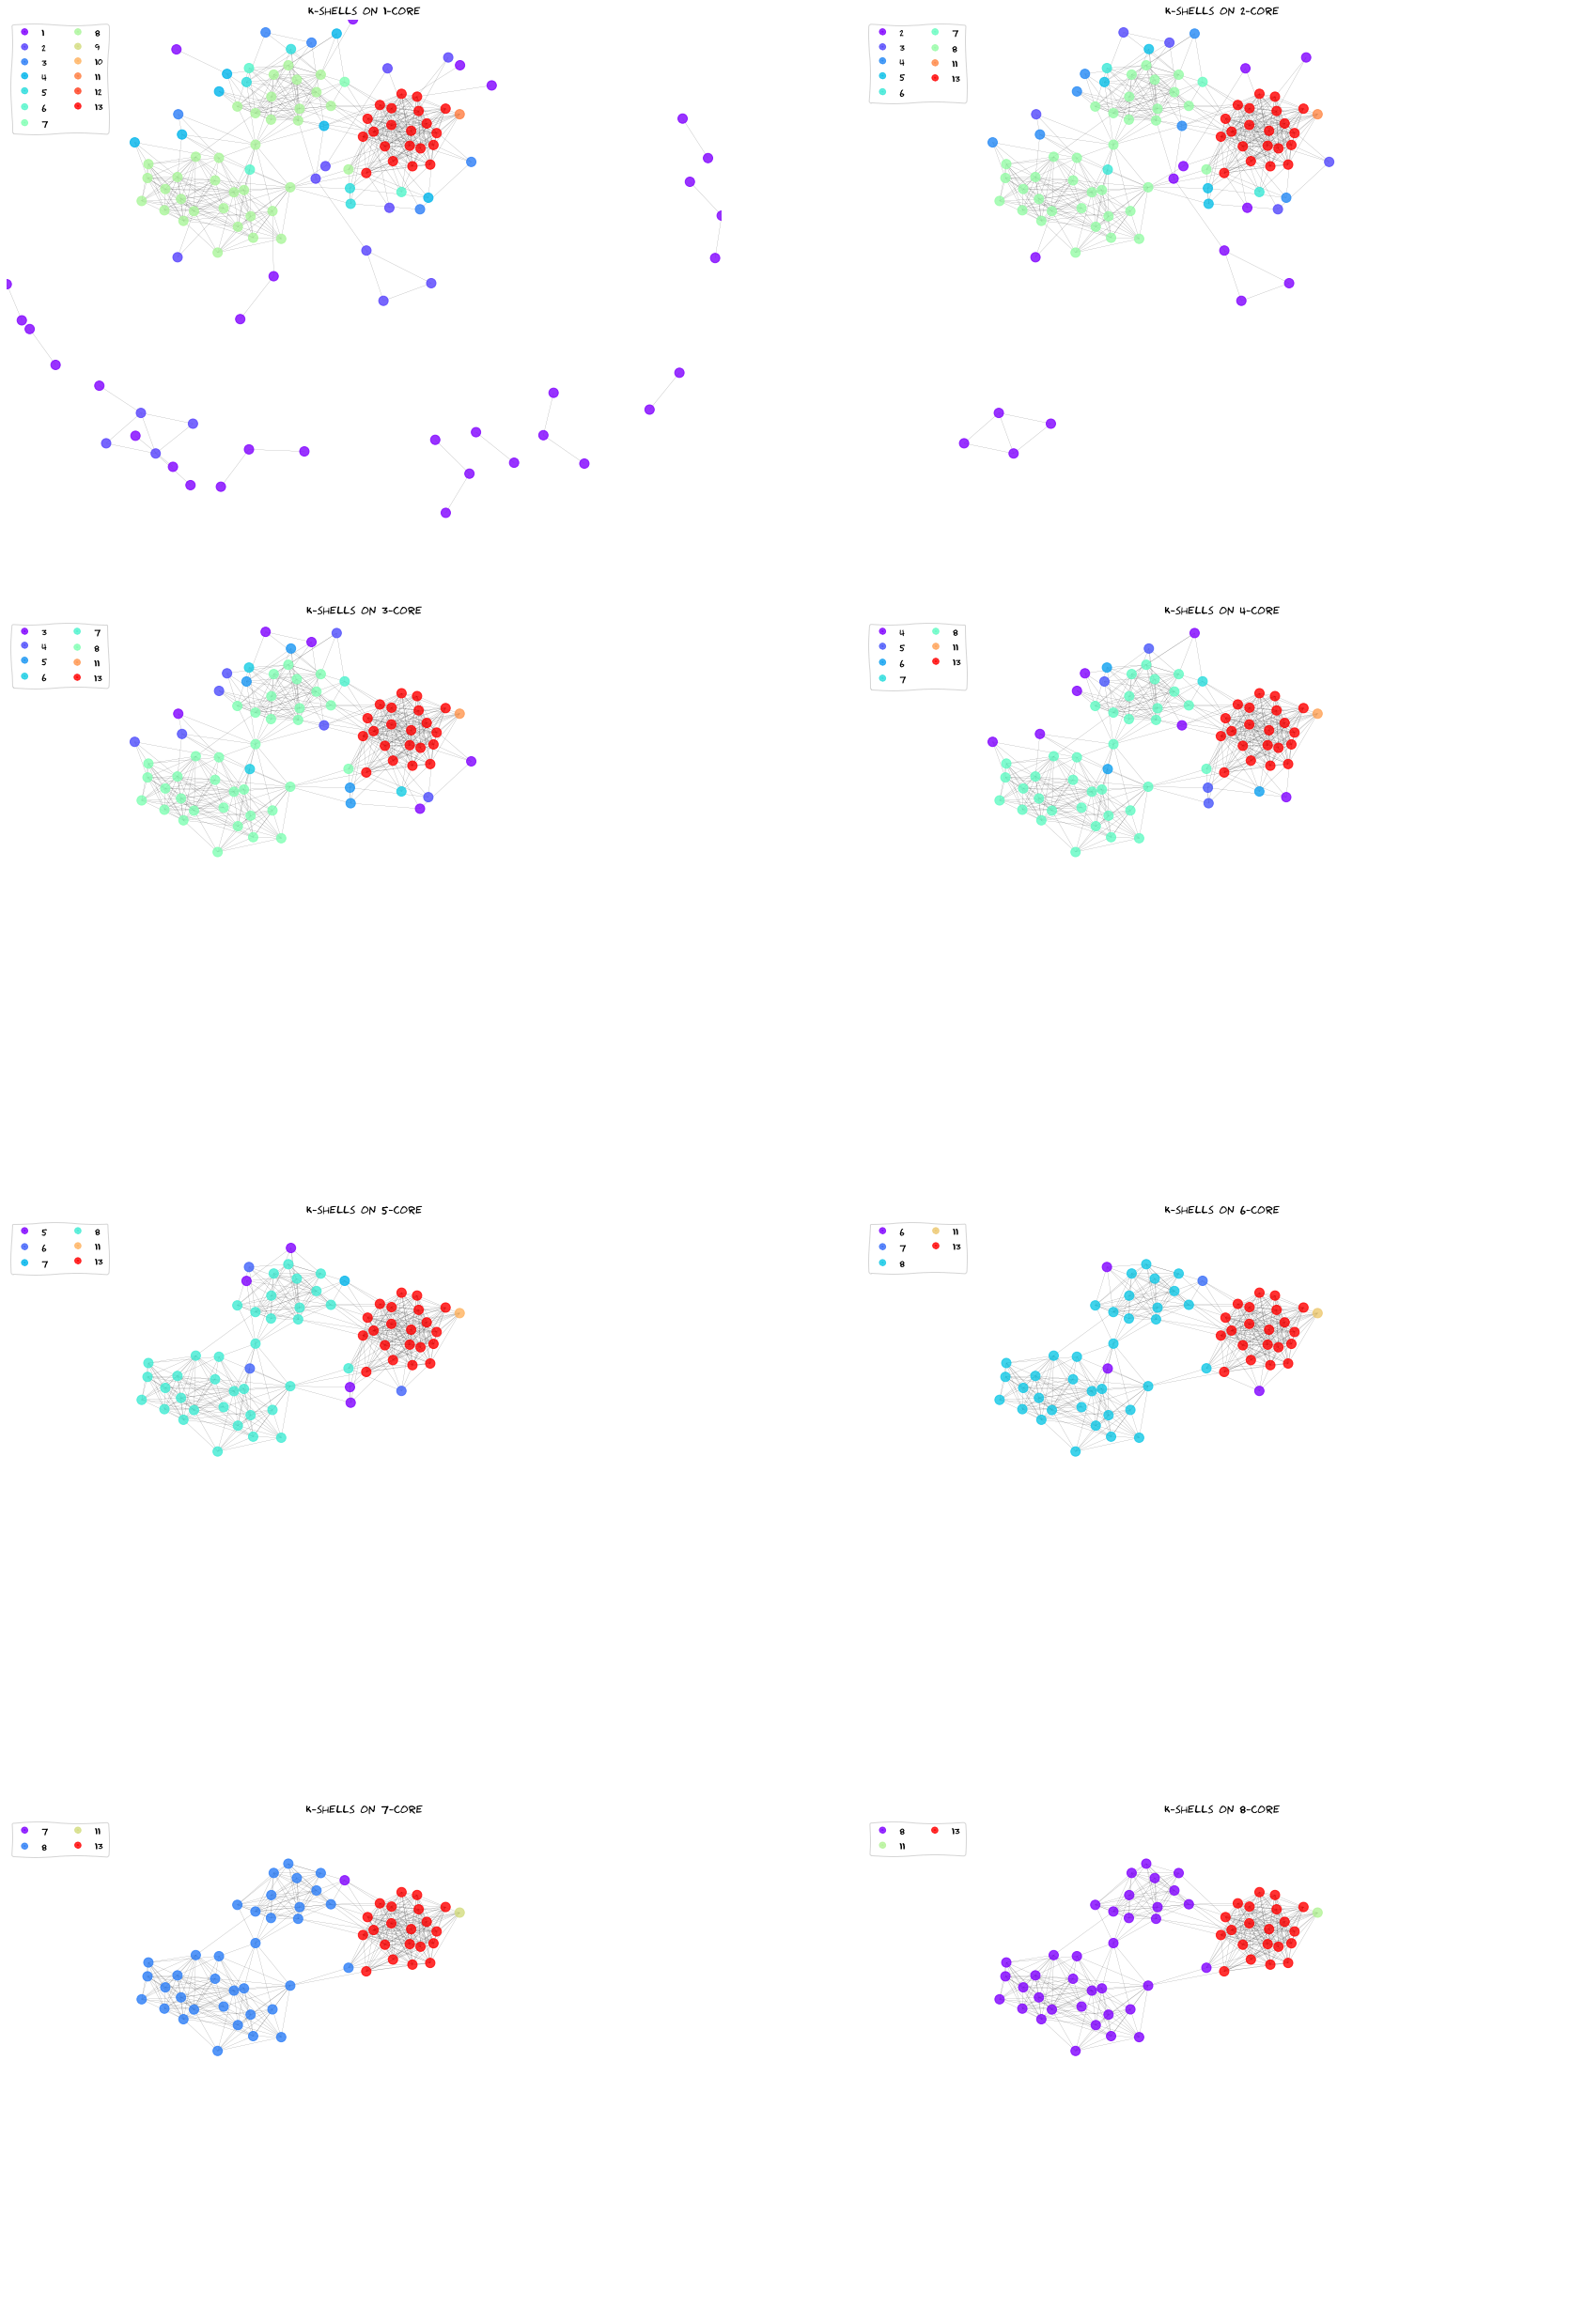

In [31]:
my_cmap = customized_color('plasma', 0.4)
plt.figure(figsize=(30, 45))

x_max, y_max = np.array(list(pos.values())).max(axis=0)
x_min, y_min = np.array(list(pos.values())).min(axis=0)

for i in range(8):
    plt.subplot(4, 2, i+1)
    subG = nx.k_core(G, i+1)
    nodes = nx.draw_networkx_nodes(
        subG, 
        pos=pos,
        cmap=plt.get_cmap('rainbow'),
        node_color=k_core_decompose(subG), 
        node_size=100,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        subG, 
        pos=pos,
        width=0.1
    )
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(*nodes.legend_elements(), loc="upper left", ncol=len(nodes.legend_elements()))
    plt.axis('off')
    plt.title('k-shells on {}-core'.format(i+1))

2.   Best results of various community detection algorithms, both in terms of interpretation and some quality criterion (modularity, silhouette, ground truth partition).
3.   The results should be visible on the network layout.
4.   Interpretations should be written over image with community detection (use Paint, for e.g.)

Modularity

In [32]:
def edge_betw_modularity(G, n):
    res = []
    comm_gen = nx.algorithms.community.girvan_newman(G)
    for i in range(n):
        part = next(comm_gen)
        res.append(nx.algorithms.community.modularity(G, part))
    return np.array(res)

n_iterations = 20
modularity = edge_betw_modularity(G, n_iterations)

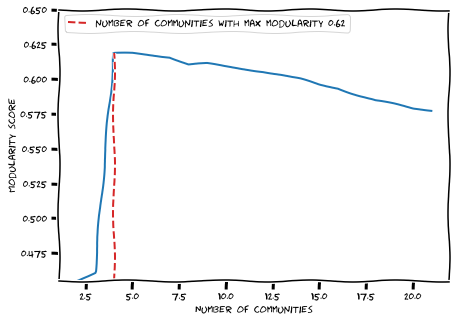

In [33]:
plt.figure(figsize=(7, 5))
plt.plot(np.arange(n_iterations)+2, modularity)
best_n = np.argmax(modularity) + 2
label = 'number of communities with max modularity {:.2f}'.format(max(modularity))
plt.plot(
    [best_n, best_n], [min(modularity), max(modularity)], 
    'k--', c='tab:red', 
    label=label
)
plt.ylabel('Modularity score')
plt.xlabel('Number of communities')
plt.legend(loc='upper left')
plt.ylim((modularity.min(), 0.65))
plt.show()

In [34]:
def edge_betweenness(G, n):
    Gcopy = G.copy()
    curr_cc_count = nx.number_connected_components(Gcopy)
    result = []
    while curr_cc_count <= n:
        edge_btw = nx.edge_betweenness_centrality(Gcopy)
        cut_edge = sorted(edge_btw.keys(), key=lambda x: edge_btw[x])[-1]
        Gcopy.remove_edge(*cut_edge)
        if nx.number_connected_components(Gcopy) > curr_cc_count:
            iter_result = np.zeros((Gcopy.number_of_nodes()))
            for idx, cc in enumerate(nx.connected_components(Gcopy)):
                iter_result[np.isin(G.nodes, list(cc))] = idx
            result.append(iter_result)
            curr_cc_count += 1
    return np.array(result)

labels = edge_betweenness(G, 6)

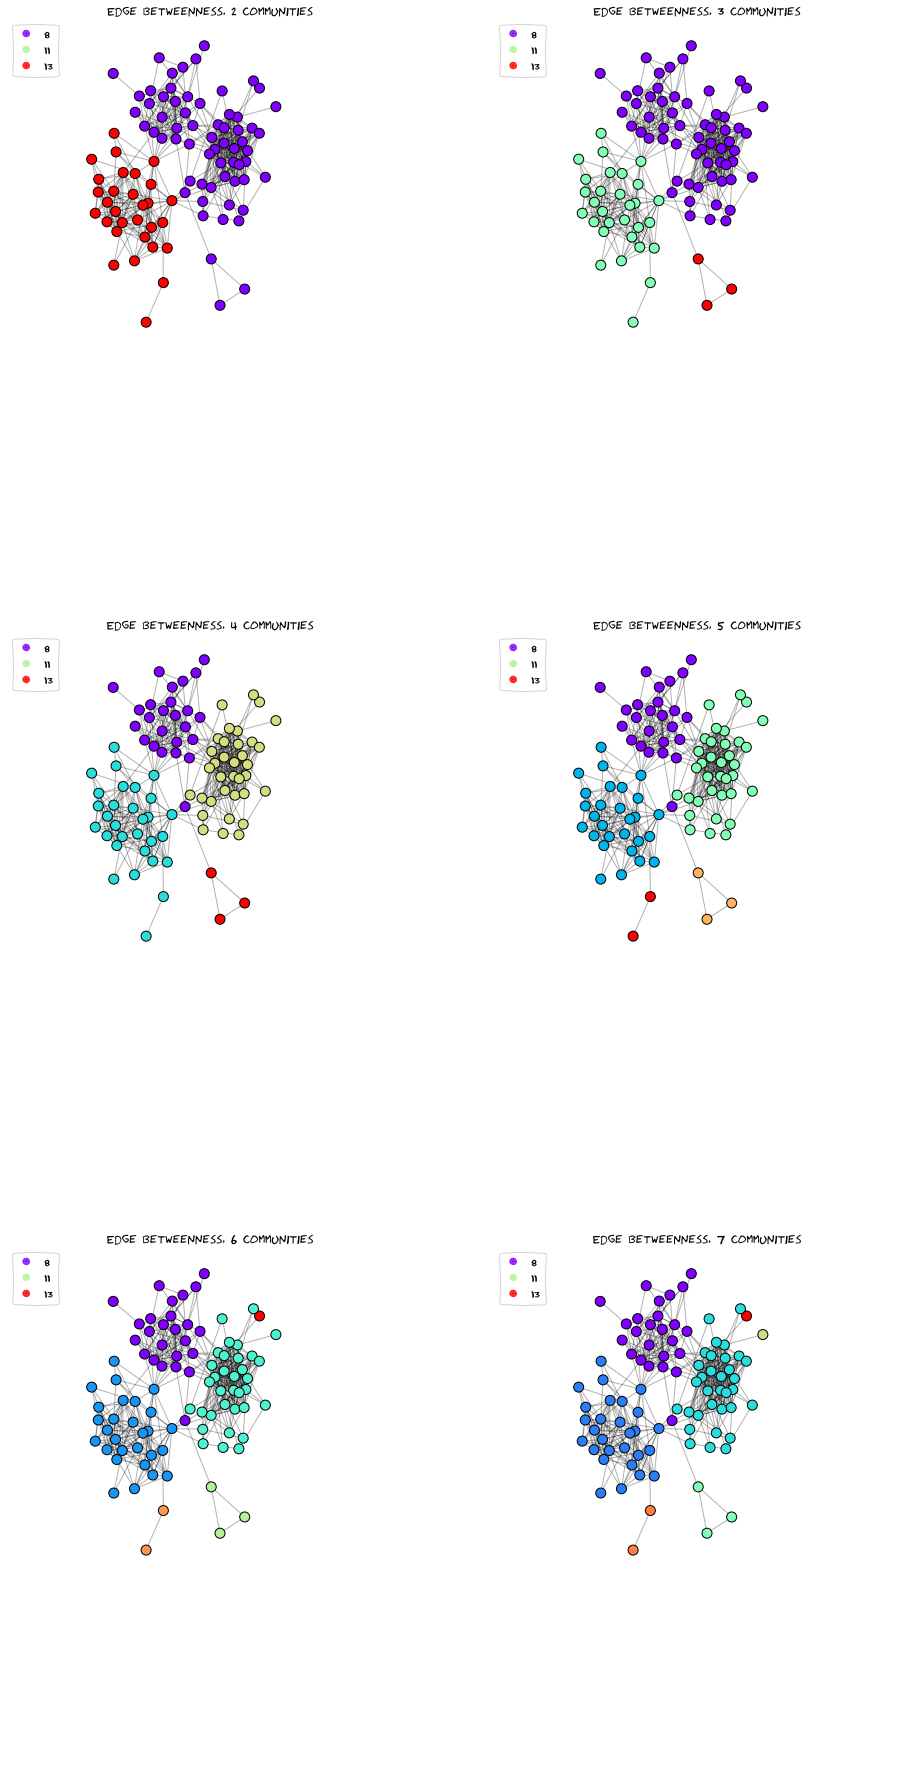

In [35]:
plt.figure(figsize=(8*2, 8*4))
colors = edge_betweenness(gig_component, 6)
for i in range(colors.shape[0]):
    plt.subplot(3, 2, i+1)
    nx.draw_networkx_nodes(
        gig_component, 
        pos,
        cmap=plt.cm.rainbow,
        node_color=colors[i], 
        node_size=100, 
        edgecolors='black'
    )
    nx.draw_networkx_edges(gig_component, pos, alpha=0.3)
    
    eps = (x_max - x_min) * 0.05
    plt.xlim(x_min-eps, x_max+eps)
    plt.ylim(y_min-eps, y_max+eps)
    plt.legend(*nodes.legend_elements(), loc="upper left")
    plt.axis('off')
    plt.title('Edge betweenness, {} communities'.format(i+2))

Laplacian Eigenmaps

In [36]:
def norm_laplacian(A):
    node_degrees = np.array(A.sum(axis=1))
    D = node_degrees**-0.5
    D_prime = np.diag(D)
    L = np.matmul(np.matmul(D_prime, (np.diag(node_degrees)-A)), D_prime)
    vals, vecs = np.linalg.eigh(L)
    pos = np.argsort(vals)
    vecs = vecs[:, pos]
    vals = vals[pos]
    for i in range(len(node_degrees)):
        vecs[i] /= np.sqrt(1/node_degrees[i])
    
    laplacian_eigenmaps = vecs[:, 1:]
    k_means = KMeans(len(node_degrees)).fit(laplacian_eigenmaps)
    
    return L, k_means.labels_


def spectral_embedding(L, degree_seq, n_components):
    vals, vecs = np.linalg.eigh(L)
    pos = np.argsort(vals)
    vecs = vecs[:, pos]
    vals = vals[pos]
    return vecs[:, 1: n_components+1]


def spectral_clustering(G, n_clusters, n_components):
    A = nx.to_numpy_array(G)
    L, degree_seq = norm_laplacian(A)
    embedding = spectral_embedding(L, degree_seq, n_components)
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    return kmeans.labels_

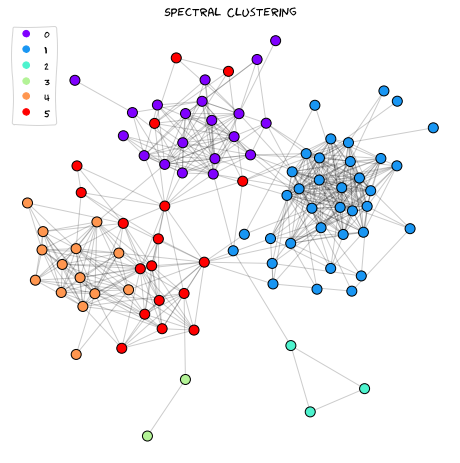

In [37]:
plt.figure(figsize=(8, 8))
nodes = nx.draw_networkx_nodes(
    gig_component, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=spectral_clustering(gig_component, 6, 5), 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    gig_component,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.axis('off')
plt.legend(*nodes.legend_elements(), loc="upper left")
plt.title('Spectral Clustering')
plt.show()

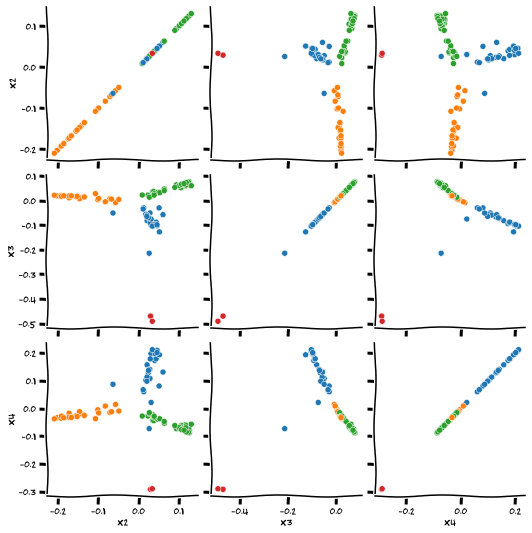

In [38]:
A = nx.to_numpy_array(gig_component)
L, degree_seq = norm_laplacian(A)

embedding = spectral_embedding(L, degree_seq, 3)
labels = spectral_clustering(gig_component, 4, 3)
pair_data = pd.DataFrame(
    np.hstack([embedding, labels[:, None]]), 
    columns=['x2', 'x3', 'x4', 'label'])
pair_data.label = pair_data.label.astype('str')
p = sns.pairplot(
    pair_data,
    hue='label',
    diag_kind=None
)
p._legend.remove()
plt.show()

In [39]:
def simrank_distance(G):
    return np.around(1 - nx.simrank_similarity_numpy(G), decimals = 7)



def agglomerative_clustering(distance, max_distance):
    clusters = AgglomerativeClustering(n_clusters=None,
                                       affinity='precomputed',
                                       compute_full_tree=True,
                                       linkage='complete', 
                                       distance_threshold=max_distance)
    clusters.fit(distance)
    return clusters.labels_

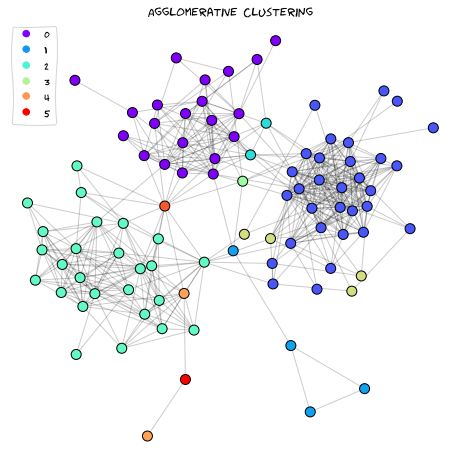

In [40]:
distance = simrank_distance(gig_component)
labels = agglomerative_clustering(distance, 0.87)
plt.figure(figsize=(8, 8))
nx.draw_networkx_nodes(
    gig_component, 
    pos,
    cmap=plt.cm.rainbow,
    node_color=labels, 
    node_size=100, 
    linewidths=1, 
    edgecolors='black'
)
nx.draw_networkx_edges(
    gig_component,
    pos,
    alpha=0.2,
    edge_color='black'
)
plt.legend(*nodes.legend_elements(), loc="upper left")
plt.title('Agglomerative Clustering')
plt.axis('off')
plt.show()